In [1]:
%load_ext autotime
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import skvideo.io
from skimage.filters import sobel

points = []
def mouse_callback(event,x,y,flags,param):
    if event == cv.EVENT_LBUTTONDOWN:
        cv.circle(img_tmp, (x, y), 5, (0, 255, 0), -1)
        points.append((y,x))

h, w = (1000, 1000)
finished = False
img = cv.cvtColor(cv.imread("tasbih.jpg"), cv.COLOR_BGR2RGB)
img_tmp = img.copy()
cv.destroyAllWindows()
cv.namedWindow('image', cv.WINDOW_NORMAL,)
cv.setWindowTitle("image", "Press Esc to close and Left mouse to select point")
cv.resizeWindow('image', w, h) #Reasonable size window
cv.setMouseCallback('image', mouse_callback) #Mouse callback
while(not finished):
    cv.imshow('image', img_tmp)
    k = cv.waitKey(4) & 0xFF
    if k == 27:
        break
cv.destroyAllWindows()

img_gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
sobelx = cv.Sobel(img_gray, cv.CV_64F, 1, 0, ksize=5)
sobely = cv.Sobel(img_gray, cv.CV_64F, 0, 1, ksize=5)
print(sobelx.shape, sobely.shape)
print(sobelx.min(), sobelx.max())

(828, 1104) (828, 1104)
-6913.0 4749.0


In [3]:
def calc_inter(sobelx, sobely, v1):
    return (sobelx[v1[0]][v1[1]])**2 + (sobely[v1[0]][v1[1]])**2

def distance(v1, v2):
    return np.sqrt((v1[0] - v2[0])**2 + (v1[1] - v2[1])**2)

def calc_exter(v1, v2):
    return np.abs(dists - distance(v1, v2)**2)

def calc_energy(sobelx, sobely, alpha, v1, v2):
    return alpha*calc_exter(v1, v2) - calc_inter(sobelx, sobely, v1)

def calc_sum_energy(sobelx, sobely, points, alpha):
    e = 0
    for point, npoint in zip(points[:-1], points[1:]):
        e += calc_energy(sobelx, sobely, alpha, point, npoint)
    return e

def calc_change(sobelx, sobely, alpha, v1_n, v2_n, v1_o, v2_o):
    return calc_energy(sobelx, sobely, alpha, v1_n, v2_n) - calc_energy(sobelx, sobely, alpha, v1_o, v2_o)

def find_next_pos(sobelx, sobely, alpha, v0, v1, v2):
    vn = np.array(v1)
    candids = []
    rng = 11
    for i in range(-rng, rng+1):
        for j in range(-rng, rng+1):
            vn[0] = max(min(v1[0] + i, sobelx.shape[0]), 0)
            vn[1] = max(min(v1[1] + j, sobelx.shape[1]), 0)
            candids.append([calc_change(sobelx, sobely, alpha, vn, v2, v1, v2) +
                           calc_change(sobelx, sobely, alpha, v0, vn, v0, v1), i, j])
    candids = sorted(candids, key=lambda x: x[0])
    i, j = (candids[0][1], candids[0][2])
    if i == 0 and j == 0:
        return 0, 0
    if i == 0:
        if j > 0:
            return 0, 1
        else:
            return 0, -1
    if i > 0:
        if j > 0:
            return 1, 1
        else:
            return 1, -1
    else:
        if j > 0:
            return -1, 1
        else:
            return -1, -1

time: 16.6 ms


<div dir="rtl">
برای انجام این تمرین از تعریف انرژی بیان شده در کلاس استفاده می کنیم که حاصل جمع وزن دار مقدار گرادیان در نقاط و میزان فاصله نقاط است.
برای پیدا کردن نقطه بهینه بعدی، هر نقطه حول خودش جستجو می کنیم و یک واحد در راستای بهینه حرکت می کند، یعنی به یکی از ۸ مربع اطراف می رود و یا ثابت می ماند ولی برای محاسبه اینکه به کدام نقطه رود، از مربع بزرگتری استفاده می کنیم.
<div dir="rtl">
</div>    
هر چه تعداد نقاط اولیه در کانتور بیشتر باشد، با دقت بیشتری تسبیح را می پوشاند و هرچه نقاط به تسبیه نزدیک باشند، خروجی بیشتر به دور تسبیح می چسبد
</div>

Video size:  (828, 1104)
188066773.6881316


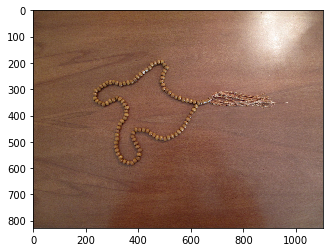

-518382025.990056


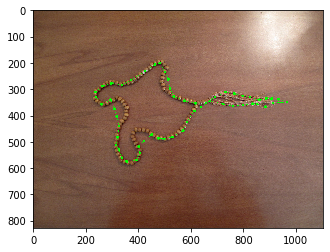

233

time: 46 s


In [6]:
iter_num = 25
alpha = 2500
points_tmp = points
fps = 10
frame_size = img.shape[:2]

print("Video size: ", frame_size)
codec = cv.VideoWriter_fourcc(*"DIVX")
# writer = cv.VideoWriter("movie01.mp4", codec, fps, frame_size)
dists = np.sum([distance(x, y) for x,y in zip(points_tmp[:-1],points_tmp[1:])])/(len(points_tmp)-1)
print(calc_sum_energy(sobelx, sobely, points, alpha))

plt.imshow(img)
plt.show()
vid = [img_tmp]
writer = skvideo.io.FFmpegWriter("movie01.mp4")

for r in range(iter_num):
    dists = np.sum([distance(x, y) for x,y in zip(points_tmp[:-1],points_tmp[1:])])/(len(points_tmp)-1)
    tmp_arr = []
    for p, npoint in zip(points_tmp[:-1], points_tmp[1:]):
        if distance(p, npoint) > dists/1.9:
            tmp_arr.append(p)
        if distance(p, npoint) > dists*1.6:
            tmp_arr.append([(p[0]+npoint[0])//2,(p[1]+npoint[1])//2])
    tmp_arr.append(points_tmp[-1])
    points_tmp = tmp_arr
    dists = (dists*4)/5
    npoints = []
    v0, v1, v2 = points_tmp[-1], points_tmp[0], points_tmp[1]
    i, j = find_next_pos(sobelx, sobely, alpha, v0, v1, v2)
    npoints.append((v1[0] + i, v1[1] + j))
    for v0, v1, v2 in zip(points_tmp[:-2], points_tmp[1:-1], points_tmp[2:]):
        i, j = find_next_pos(sobelx, sobely, alpha, v0, v1, v2)
        npoints.append((v1[0] + i, v1[1] + j))
    v0, v1, v2 = points_tmp[-2], points_tmp[-1], points_tmp[0]
    (i, j) = find_next_pos(sobelx, sobely, alpha, v0, v1, v2)
    npoints.append((v1[0] + i, v1[1] + j))
    points_tmp = npoints
    
    img_tmp = img.copy()
    cv.polylines(img_tmp,[np.array([[y,x] for x, y in points_tmp], dtype=np.int32)],True,(0,255,0))
    for p in points_tmp:
        cv.circle(img_tmp, (p[1], p[0]), 5, (0, 255, 0), -1)
    cv.imshow('frame', img_tmp)
    c = cv.waitKey(1)
    vid.append(img_tmp)
    writer.writeFrame(img_tmp)
    

dists = np.sum([distance(x, y) for x,y in zip(points_tmp[:-1],points_tmp[1:])])/(len(points_tmp)-1)
print(calc_sum_energy(sobelx, sobely, points_tmp, alpha))
plt.imshow(img_tmp)
plt.imsave("im10.jpg", img_tmp)
plt.show()

        
writer.close()
cv.waitKey(0)

<div dir="rtl">
جهت بهبود نتیجه از تکنیک استفاده از میانگین فاصله و کاهش آن استفاده کرده ایم تا نقاط با شیب مناسب به هم نزدیک شوند و نه به یک نقطه میل کنند و نه از یکدیگر دور بمانند
</div>